# Keypoint Detection using Mask R-CNN

In this notebook, we will introduce keypoint detection.  Keypoints are meaningful points of an object detected in an image.  For example, facial or body keypoint detection can be used for emotion and pose recognition.   We will demostrate how to do human body keypoints detection using the pretrained Keypoint R-CNN model in PyTorch.  The Keypoint R-CNN is described in [Mask R-CNN](https://arxiv.org/abs/1703.06870) as well.

## Initialization

In [1]:
# ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# imports
from PIL import Image
import scrapbook as sb
import urllib.request

# torch
import torch

# utility
import sys
sys.path.append("../../")

from utils_cv.common.data import data_path
from utils_cv.common.gpu import which_processor
from utils_cv.detection.data import coco_labels
from utils_cv.detection.keypoint import COCOPersonKeypoints
from utils_cv.detection.model import DetectionLearner, get_pretrained_keypointrcnn
from utils_cv.detection.plot import display_annotations, PlotSettings

# variables
device = torch.device('cuda')

which_processor()

Torch is using GPU: Quadro P400


## Preparation

We will use an image from the Internet.

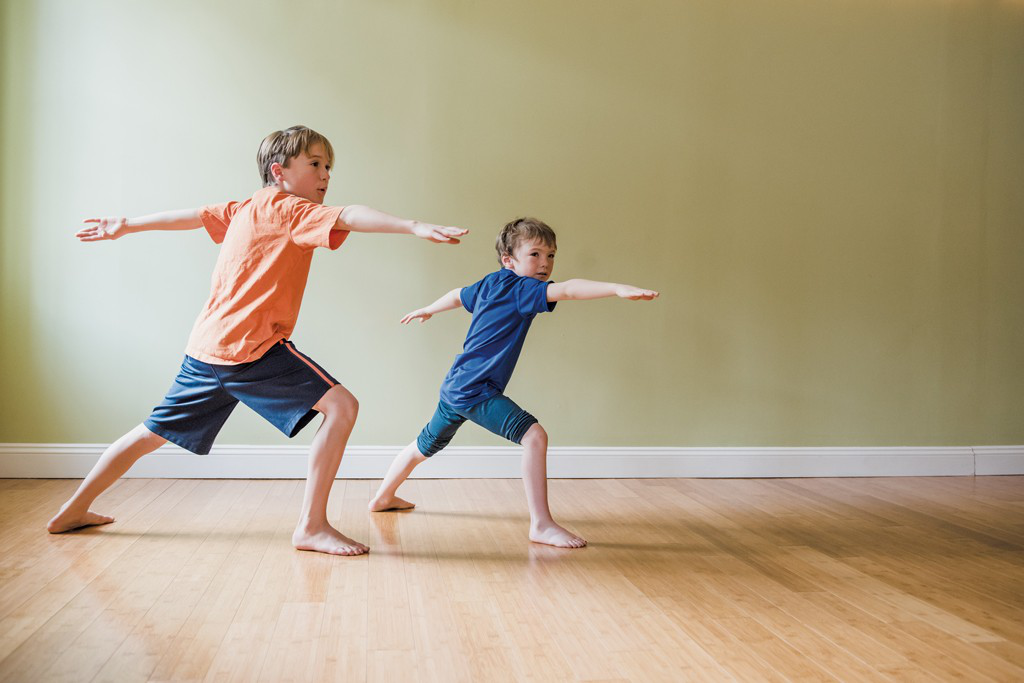

In [3]:
# download image
img_url = "https://media1.fdncms.com/kidsvt/imager/u/original/4282458/yogaposeofthemonth1-1-28d965b85e30c074.jpg"
img_path = data_path() / img_url.split('/')[-1]
urllib.request.urlretrieve(img_url, img_path)

# show image
Image.open(img_path)

Similar to [01_training_introduction notebook](https://render.githubusercontent.com/view/01_training_introduction.ipynb), we can use `get_pretrained_keypointrcnn()` to get the pretrained Keypoint R-CNN model in PyTorch to create a `DetectionLearner`.

In [4]:
# get pretrained keypoint rcnn model
detector = DetectionLearner(
    model=get_pretrained_keypointrcnn(),
    labels=coco_labels()[1:],
    device=device,
)

The pretrained model is built on the [COCO train2017 dataset (118K/18GB)](http://images.cocodataset.org/zips/train2017.zip) with 17 annotated human body keypoints.

In [5]:
[(index, label) for index, label in enumerate(COCOPersonKeypoints.labels)]

[(0, 'nose'),
 (1, 'left_eye'),
 (2, 'right_eye'),
 (3, 'left_ear'),
 (4, 'right_ear'),
 (5, 'left_shoulder'),
 (6, 'right_shoulder'),
 (7, 'left_elbow'),
 (8, 'right_elbow'),
 (9, 'left_wrist'),
 (10, 'right_wrist'),
 (11, 'left_hip'),
 (12, 'right_hip'),
 (13, 'left_knee'),
 (14, 'right_knee'),
 (15, 'left_ankle'),
 (16, 'right_ankle')]

Keypoints of an object can be connected by edges in some order for visualization.

In [6]:
COCOPersonKeypoints.skeleton

[[15, 13],
 [13, 11],
 [16, 14],
 [14, 12],
 [11, 12],
 [5, 11],
 [6, 12],
 [5, 6],
 [5, 7],
 [6, 8],
 [7, 9],
 [8, 10],
 [1, 2],
 [0, 1],
 [0, 2],
 [1, 3],
 [2, 4],
 [3, 5],
 [4, 6]]

## Prediction

The results from `DetectionLearner.predict()` is a `Dict` contains `det_bboxes` and `keypoints`.

In [7]:
# predict
pred = detector.predict(img_path, threshold=0.6)
pred["det_bboxes"]

[{Bbox object: [left=42, top=134, right=443, bottom=554] | <person> | label:1 | path:/home/simon/Copy/Projects/work/vb/cvbp/repo/fork-cvbp/data/yogaposeofthemonth1-1-28d965b85e30c074.jpg} | score: 0.9999191761016846,
 {Bbox object: [left=368, top=217, right=649, bottom=552] | <person> | label:1 | path:/home/simon/Copy/Projects/work/vb/cvbp/repo/fork-cvbp/data/yogaposeofthemonth1-1-28d965b85e30c074.jpg} | score: 0.9999122619628906]

A keypoint is represented by its coordinate and visibility in the image.  `0` means invisible and `1` visible.

In [8]:
pred["keypoints"]

array([[[323.26956, 173.23006,   1.     ],
        [322.41705, 163.84776,   1.     ],
        [313.8922 , 162.99483,   1.     ],
        [278.08774, 170.67126,   1.     ],
        [279.7927 , 170.67126,   1.     ],
        [242.28323, 207.34753,   1.     ],
        [294.28497, 209.90634,   1.     ],
        [192.83896, 215.87689,   1.     ],
        [349.6967 , 216.72983,   1.     ],
        [128.04988, 224.40627,   1.     ],
        [408.51834, 225.2592 ,   1.     ],
        [208.18372, 348.93503,   1.     ],
        [257.62802, 352.34674,   1.     ],
        [151.91954, 434.2287 ,   1.     ],
        [343.72928, 411.19937,   1.     ],
        [ 72.63818, 509.28708,   1.     ],
        [311.33472, 526.3458 ,   1.     ]],

       [[544.94995, 263.02124,   1.     ],
        [550.06683, 253.64337,   1.     ],
        [534.7163 , 253.64337,   1.     ],
        [504.86823, 259.6111 ,   1.     ],
        [508.27945, 259.6111 ,   1.     ],
        [488.66498, 281.77704,   1.     ],
        [

## Visualization

Likewise, we can use `display_annotations()` to visulize the predicted bounding boxes and keypoints.

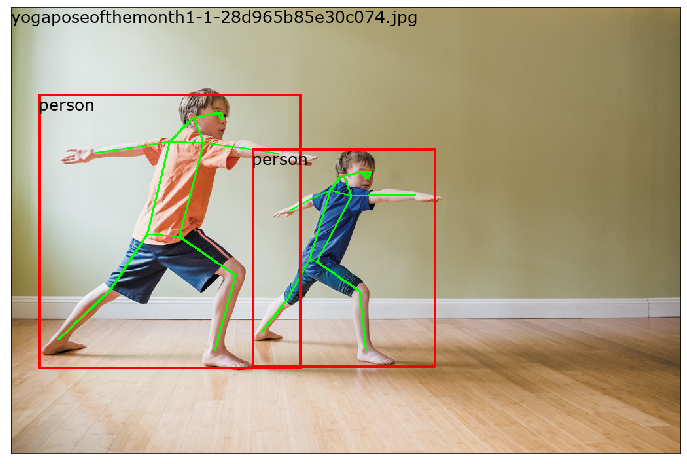

In [9]:
# plot
plot_settings = PlotSettings(
    text_color=(0, 0, 0),
    keypoint_color=(0, 255, 0),
)
display_annotations(
    pred["det_bboxes"], 
    img_path,
    keypoints=pred["keypoints"],
    plot_settings=plot_settings,
)

## Conclusion

In this notebook, we use the pretrained Keypoint R-CNN model extended from Mask R-CNN to detect keypoints.